# E-Commerce Data Analysis for Recommendation System



## 1. Setup & Database Connection

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Style settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

In [21]:
# Database connection
DB_CONFIG = {
    'host': 'localhost',
    'port': 3306,
    'database': 'ecommerce_db',
    'user': 'root',
    'password': 'root'
}

# Create SQLAlchemy engine
engine = create_engine(
    f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@"
    f"{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
)

print("Database connection established!")

Database connection established!


## 2. Load Raw Data

In [22]:
# Load orders (only successful orders)
query_orders = """
SELECT 
    HEX(id) as order_id,
    HEX(user_id) as user_id,
    order_status,
    payment_status,
    created_at,
    confirmed_at,
    delivered_at
FROM orders
WHERE order_status IN ('CONFIRMED', 'DELIVERED', 'SHIPPED')
  AND is_active = 1
ORDER BY created_at DESC
"""

df_orders = pd.read_sql(query_orders, engine)
print(f"Orders: {len(df_orders):,} rows")
df_orders.head()

Orders: 4,498 rows


,order_id,user_id,order_status,payment_status,created_at,confirmed_at,delivered_at
0,A487B04C42DA4AB59EA7D8730BE69AF9,E06384C1443347D3B03BE62D34E75B9C,CONFIRMED,PAID,2025-11-04 23:20:09.676367,2025-11-04 23:20:09.676367,NaT
1,8BEA4E7F065C42AF95A1C4984EDEE440,4A0744BBEBD04D328C48CAC30491A726,CONFIRMED,PAID,2025-11-04 23:12:35.676367,2025-11-04 23:12:35.676367,NaT
2,04AD6E88D15F4640930DA9A1739A6DD1,CD2C649F7531440588A57EF2262CDB46,CONFIRMED,PAID,2025-11-04 23:07:27.676367,2025-11-04 23:07:27.676367,NaT
3,DE69058C22964B5B90D2EE3A99BC0522,305AF675B5094C5AA566E95ACA2227CF,DELIVERED,PAID,2025-11-04 23:06:40.676367,2025-11-04 23:06:40.676367,2025-11-04 23:06:40.676367
4,F512A5FF162543D6878BD1460F33FDEC,C4DE6AD4F73547E29559D4BDE13C1BE0,DELIVERED,PAID,2025-11-04 23:03:24.676367,2025-11-04 23:03:24.676367,2025-11-04 23:03:24.676367


In [23]:
# Load order items
query_order_items = """
SELECT 
    HEX(oi.id) as item_id,
    HEX(oi.order_id) as order_id,
    HEX(oi.variant_id) as variant_id,
    HEX(pv.product_id) as product_id,
    oi.product_name,
    oi.quantity,
    oi.price,
    oi.created_at
FROM order_items oi
JOIN product_variants pv ON oi.variant_id = pv.id
WHERE oi.is_active = 1
"""

df_order_items = pd.read_sql(query_order_items, engine)
print(f"Order Items: {len(df_order_items):,} rows")
df_order_items.head()

Order Items: 8,905 rows


,item_id,order_id,variant_id,product_id,product_name,quantity,price,created_at
0,000163CD7D73480AB18F3F0C93BAFCA5,CF0AC1803C9D4E90B5BBD9F4031C937A,2B0D2F7307F7477EA6F220D4AAFDC2E0,A8EE15B067364544B975986B953AA5DC,WD Black SN850X,1,139.99,2025-10-02 14:57:00.676367
1,0003468330054CCC90ED1E2D24C9F4BC,015791EDADA74D51BA704C6D1E7C907C,A6F8CFC6978B4576A0D642EC99E695CF,BA6F86D76CA44499AEE9108F60A9A476,AMD Ryzen 9 7950X,1,699.99,2025-05-10 00:06:08.676367
2,000E41E8014E4A78B4DDB0CD6DFA6A26,888EA5610268409FB1508B8C81F42F68,EFD911F8A7F340D9BC0395F96DB52E35,25BB55DAFE254A358396CC98410FB5C0,BenQ ZOWIE XL2546K,3,549.99,2025-09-20 06:41:20.676367
3,000F218D00C545FDA7F017049BD8E689,09C0DB98EA93439B8642B98FE13E4BED,BC4590B959AB4B2BB74185BB043E6919,E51F995C9AEE4A7E9410EB3B1B0EDBE8,SteelSeries QcK Heavy,1,29.99,2025-11-04 16:42:11.676367
4,002E0D1818FA4142B7A85E80DCF681B1,A4A355F4988B4283A2EB19D3ED63C787,BC4590B959AB4B2BB74185BB043E6919,E51F995C9AEE4A7E9410EB3B1B0EDBE8,SteelSeries QcK Heavy,1,29.99,2025-05-31 20:28:18.676367


In [24]:
# Load user product views
query_views = """
SELECT 
    HEX(user_id) as user_id,
    HEX(product_id) as product_id,
    view_count,
    last_viewed_at,
    created_at
FROM user_product_views
"""

df_views = pd.read_sql(query_views, engine)
print(f"Product Views: {len(df_views):,} rows")
df_views.head()

Product Views: 3,173 rows


,user_id,product_id,view_count,last_viewed_at,created_at
0,00865C51DFA045A7AD4F510E366CCFCB,0840E707EDFC4C31AA5097D0F004A8CE,3,2025-05-26 17:15:14.676367,2025-07-02 21:06:36.676367
1,00925D0E0A3B4F668AC6521C4525555E,0840E707EDFC4C31AA5097D0F004A8CE,6,2025-05-21 05:32:28.676367,2025-06-19 22:21:31.676367
2,054AF889BC5E4AAE947C0AC124803AE8,0840E707EDFC4C31AA5097D0F004A8CE,1,2025-06-06 13:48:45.676367,2025-05-15 01:26:54.676367
3,094B9067489349A1BDCCE008413E7DDE,0840E707EDFC4C31AA5097D0F004A8CE,3,2025-05-26 00:57:26.676367,2025-06-03 23:18:38.676367
4,0E8949A2F260466F9ADC9D8C7FDC6F19,0840E707EDFC4C31AA5097D0F004A8CE,2,2025-05-18 09:06:42.676367,2025-09-20 01:34:32.676367


In [25]:
# Load products metadata
query_products = """
SELECT 
    HEX(id) as product_id,
    name,
    HEX(category_id) as category_id,
    HEX(brand_id) as brand_id,
    status,
    base_price,
    purchase_count,
    view_count,
    average_rating,
    total_reviews,
    created_at
FROM products
WHERE is_active = 1
  AND status IN ('ACTIVE', 'APPROVED')
"""

df_products = pd.read_sql(query_products, engine)
print(f"Products: {len(df_products):,} rows")
df_products.head()

Products: 33 rows


,product_id,name,category_id,brand_id,status,base_price,purchase_count,view_count,average_rating,total_reviews,created_at
0,0840E707EDFC4C31AA5097D0F004A8CE,AMD Ryzen 7 7800X3D,4675540E1D2944728503B5E9AE0F2697,DDFAACFA5881456C9242BDB991547234,APPROVED,449.99,61,588,NaN,0,2025-11-03 02:57:23.259063
1,1EAE17D73016409F8840E802DC599F5F,AMD Radeon RX 7900 XTX,C6D8910663B144B683702CE06F831A7E,DDFAACFA5881456C9242BDB991547234,APPROVED,999.99,90,537,NaN,0,2025-11-03 02:57:23.271493
2,25BB55DAFE254A358396CC98410FB5C0,BenQ ZOWIE XL2546K,A792DC72D49D41B8B09B2ACE617A6F17,D5D4F5B135AC4F49A301E94AA1AD7C39,APPROVED,549.99,117,999,NaN,0,2025-11-03 02:57:23.363735
3,27ABB23A419A4B05A14FEC388EC8B863,MSI MPG Z790 Carbon WiFi,82A28159F9E9477BA3F28FE8902B2181,0802550A39AA4987BA66CBEC7FC4C0F3,APPROVED,449.99,52,245,NaN,0,2025-11-03 02:57:23.326409
4,307BB36E6EE44BE5897DE0E1FDD7B270,Logitech G Pro X Superlight,78D67970800C401688DE66EDF48ED37E,75022F20C7164309B19E5C8039B0C4F6,APPROVED,149.99,190,372,NaN,0,2025-11-03 02:57:23.158688


## 3. Data Quality Assessment

In [26]:
# Merge orders with order_items to get purchase data
df_purchases = df_orders.merge(df_order_items, on='order_id', how='inner')

print("DATA QUALITY REPORT")
print("=" * 60)
print(f"Total Orders: {len(df_orders):,}")
print(f"Total Order Items: {len(df_order_items):,}")
print(f"Total Purchases (merged): {len(df_purchases):,}")
print(f"Total Product Views: {len(df_views):,}")
print(f"Total Active Products: {len(df_products):,}")
print(f"\nUnique Users (Orders): {df_purchases['user_id'].nunique():,}")
print(f"Unique Users (Views): {df_views['user_id'].nunique():,}")
print(f"Unique Products (Purchased): {df_purchases['product_id'].nunique():,}")
print(f"Unique Products (Viewed): {df_views['product_id'].nunique():,}")
print("=" * 60)

DATA QUALITY REPORT
Total Orders: 4,498
Total Order Items: 8,905
Total Purchases (merged): 8,014
Total Product Views: 3,173
Total Active Products: 33

Unique Users (Orders): 102
Unique Users (Views): 102
Unique Products (Purchased): 33
Unique Products (Viewed): 33


In [27]:
# Check for missing values
print("\nMISSING VALUES CHECK:")
print("\nPurchases:")
print(df_purchases.isnull().sum())
print("\nViews:")
print(df_views.isnull().sum())


MISSING VALUES CHECK:

Purchases:
order_id             0
user_id              0
order_status         0
payment_status       0
created_at_x         0
confirmed_at         0
delivered_at      5371
item_id              0
variant_id           0
product_id           0
product_name         0
quantity             0
price                0
created_at_y         0
dtype: int64

Views:
user_id           0
product_id        0
view_count        0
last_viewed_at    0
created_at        0
dtype: int64


## 4. User Behavior Analysis

In [28]:
# User purchase statistics
user_purchase_stats = df_purchases.groupby('user_id').agg({
    'order_id': 'nunique',  # Number of orders
    'product_id': 'nunique',  # Number of unique products
    'item_id': 'count',  # Total items purchased
    'quantity': 'sum'  # Total quantity
}).rename(columns={
    'order_id': 'num_orders',
    'product_id': 'num_unique_products',
    'item_id': 'num_items',
    'quantity': 'total_quantity'
})

print("USER PURCHASE STATISTICS:")
print(user_purchase_stats.describe())

USER PURCHASE STATISTICS:
       num_orders  num_unique_products   num_items  total_quantity
count  102.000000           102.000000  102.000000      102.000000
mean    44.098039            27.794118   78.568627       98.323529
std      7.004256             2.418322   13.916661       18.176888
min     22.000000            19.000000   45.000000       53.000000
25%     39.250000            26.000000   70.250000       86.000000
50%     44.000000            28.000000   76.500000       97.000000
75%     49.000000            30.000000   88.000000      109.750000
max     59.000000            31.000000  113.000000      141.000000


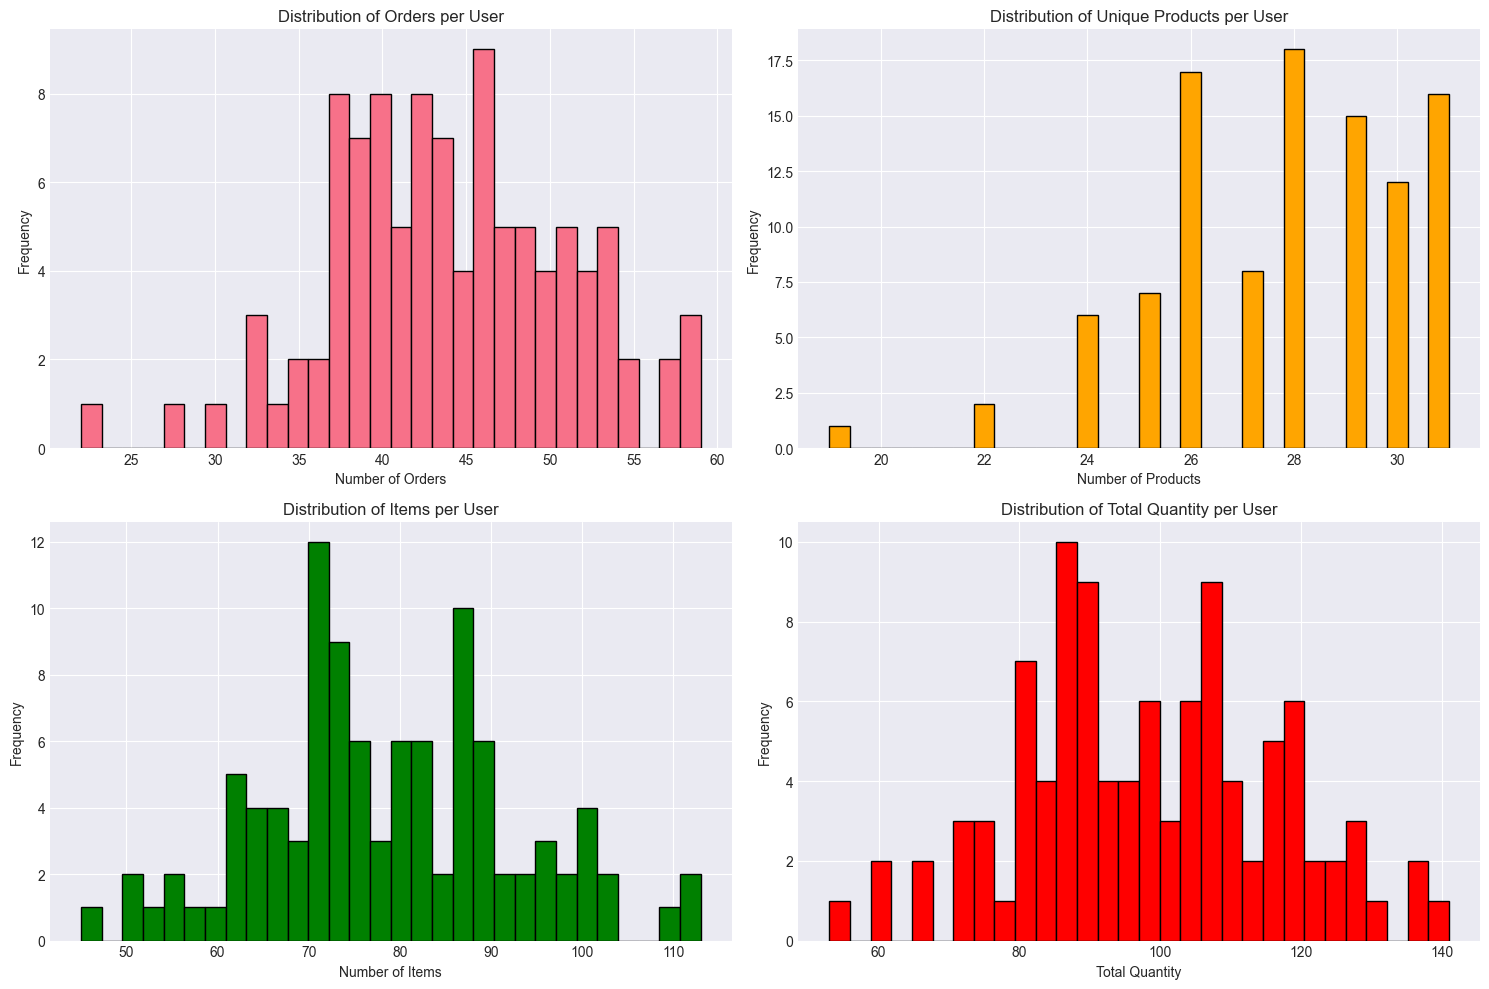

In [29]:
# Visualize user purchase distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Orders per user
axes[0, 0].hist(user_purchase_stats['num_orders'], bins=30, edgecolor='black')
axes[0, 0].set_title('Distribution of Orders per User')
axes[0, 0].set_xlabel('Number of Orders')
axes[0, 0].set_ylabel('Frequency')

# Products per user
axes[0, 1].hist(user_purchase_stats['num_unique_products'], bins=30, edgecolor='black', color='orange')
axes[0, 1].set_title('Distribution of Unique Products per User')
axes[0, 1].set_xlabel('Number of Products')
axes[0, 1].set_ylabel('Frequency')

# Items per user
axes[1, 0].hist(user_purchase_stats['num_items'], bins=30, edgecolor='black', color='green')
axes[1, 0].set_title('Distribution of Items per User')
axes[1, 0].set_xlabel('Number of Items')
axes[1, 0].set_ylabel('Frequency')

# Quantity per user
axes[1, 1].hist(user_purchase_stats['total_quantity'], bins=30, edgecolor='black', color='red')
axes[1, 1].set_title('Distribution of Total Quantity per User')
axes[1, 1].set_xlabel('Total Quantity')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [30]:
# Product popularity
product_stats = df_purchases.groupby('product_id').agg({
    'user_id': 'nunique',  # Number of unique buyers
    'item_id': 'count',  # Number of times purchased
    'quantity': 'sum'  # Total quantity sold
}).rename(columns={
    'user_id': 'num_buyers',
    'item_id': 'num_purchases',
    'quantity': 'total_sold'
}).sort_values('num_purchases', ascending=False)

print("\nPRODUCT POPULARITY (Top 10):")
print(product_stats.head(10))


PRODUCT POPULARITY (Top 10):
                                  num_buyers  num_purchases  total_sold
product_id                                                             
307BB36E6EE44BE5897DE0E1FDD7B270         102            661         825
A6BC68C1D5EC48B899BB17DE744A9D84         102            654         853
BA6F86D76CA44499AEE9108F60A9A476         102            631         781
E2C2445A70D84EC8B73536B3F0C97327         101            628         779
8878D08F78E147E5BB787FFAAE109482         102            613         769
F221EFECEB20438D989E78FEB513E1AF          87            200         240
F70B514C60A74B27B5FD93A8EF0D6F94          87            197         244
F5723D267940488BBAF0A7750DF52F50          83            194         238
5D40F0621A4A4882860B165E7EA725A7          91            194         245
E693908ECA044D3F8645A54F2250F649          84            189         231


## 5. Interaction Matrix Analysis

In [31]:
# Build user-item interaction matrix (purchases)
user_item_matrix = df_purchases.groupby(['user_id', 'product_id'])['quantity'].sum().unstack(fill_value=0)

print("USER-ITEM MATRIX (Purchases):")
print(f"Shape: {user_item_matrix.shape} (users × products)")
print(f"Total interactions: {(user_item_matrix > 0).sum().sum():,}")
print(f"Matrix size: {user_item_matrix.size:,} cells")

USER-ITEM MATRIX (Purchases):
Shape: (102, 33) (users × products)
Total interactions: 2,835
Matrix size: 3,366 cells



🎯 SPARSITY METRICS:
Total possible interactions: 3,366
Actual interactions: 2,835
Sparsity: 15.78%
Density: 84.22%

Matrix too large to visualize (sample visualization instead)


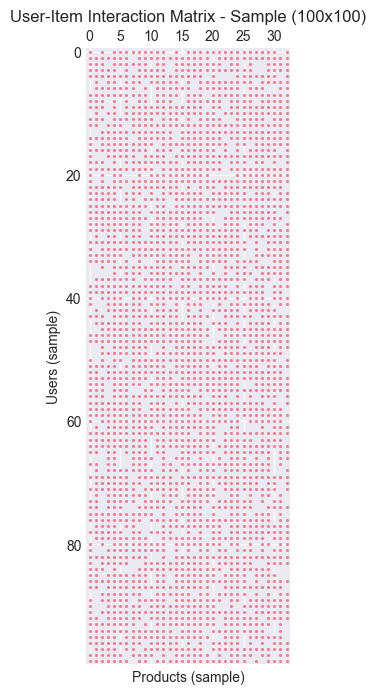

In [32]:
# Calculate sparsity
total_cells = user_item_matrix.size
non_zero_cells = (user_item_matrix > 0).sum().sum()
sparsity = 1 - (non_zero_cells / total_cells)

print(f"\n🎯 SPARSITY METRICS:")
print(f"Total possible interactions: {total_cells:,}")
print(f"Actual interactions: {non_zero_cells:,}")
print(f"Sparsity: {sparsity:.2%}")
print(f"Density: {(1-sparsity):.2%}")

# Visualize sparsity
if user_item_matrix.shape[0] <= 100 and user_item_matrix.shape[1] <= 100:
    plt.figure(figsize=(12, 8))
    plt.spy(user_item_matrix.values, markersize=1)
    plt.title('User-Item Interaction Matrix (Black = Interaction)')
    plt.xlabel('Products')
    plt.ylabel('Users')
    plt.show()
else:
    print("\nMatrix too large to visualize (sample visualization instead)")
    sample_matrix = user_item_matrix.iloc[:100, :100]
    plt.figure(figsize=(12, 8))
    plt.spy(sample_matrix.values, markersize=1)
    plt.title('User-Item Interaction Matrix - Sample (100x100)')
    plt.xlabel('Products (sample)')
    plt.ylabel('Users (sample)')
    plt.show()

## 6. Co-occurrence Analysis (Item-Item)

In [33]:
# Products bought together in same order
from itertools import combinations

# Get products per order
products_per_order = df_purchases.groupby('order_id')['product_id'].apply(list)

# Calculate co-occurrences
co_occurrence = {}
for products in products_per_order:
    if len(products) > 1:
        for prod1, prod2 in combinations(sorted(set(products)), 2):
            pair = (prod1, prod2)
            co_occurrence[pair] = co_occurrence.get(pair, 0) + 1

# Convert to DataFrame
df_cooccur = pd.DataFrame([
    {'product1': k[0], 'product2': k[1], 'count': v}
    for k, v in co_occurrence.items()
]).sort_values('count', ascending=False)

print(f"\nCO-OCCURRENCE ANALYSIS:")
print(f"Total product pairs: {len(df_cooccur):,}")
print(f"Pairs bought together 2+ times: {len(df_cooccur[df_cooccur['count'] >= 2]):,}")
print(f"Pairs bought together 5+ times: {len(df_cooccur[df_cooccur['count'] >= 5]):,}")
print(f"\nTop 10 product pairs:")
print(df_cooccur.head(10))


CO-OCCURRENCE ANALYSIS:
Total product pairs: 527
Pairs bought together 2+ times: 523
Pairs bought together 5+ times: 421

Top 10 product pairs:
                            product1                          product2  count
9   307BB36E6EE44BE5897DE0E1FDD7B270  E2C2445A70D84EC8B73536B3F0C97327    177
15  307BB36E6EE44BE5897DE0E1FDD7B270  A6BC68C1D5EC48B899BB17DE744A9D84    175
18  A6BC68C1D5EC48B899BB17DE744A9D84  E2C2445A70D84EC8B73536B3F0C97327    172
10  BA6F86D76CA44499AEE9108F60A9A476  E2C2445A70D84EC8B73536B3F0C97327    170
16  8878D08F78E147E5BB787FFAAE109482  A6BC68C1D5EC48B899BB17DE744A9D84    168
14  307BB36E6EE44BE5897DE0E1FDD7B270  8878D08F78E147E5BB787FFAAE109482    160
17  8878D08F78E147E5BB787FFAAE109482  E2C2445A70D84EC8B73536B3F0C97327    159
8   307BB36E6EE44BE5897DE0E1FDD7B270  BA6F86D76CA44499AEE9108F60A9A476    155
38  A6BC68C1D5EC48B899BB17DE744A9D84  BA6F86D76CA44499AEE9108F60A9A476    147
39  8878D08F78E147E5BB787FFAAE109482  BA6F86D76CA44499AEE9108F60A9A476    1

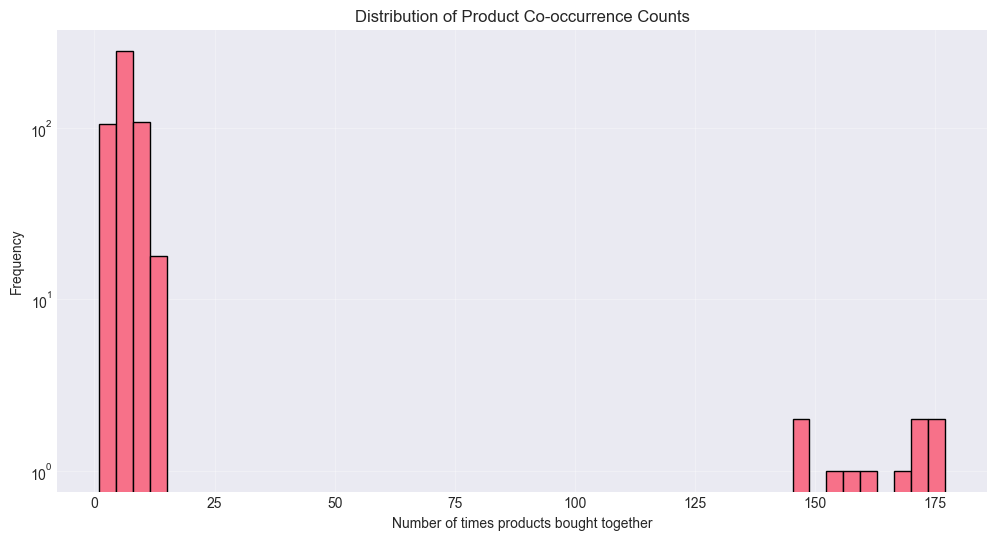

In [34]:
# Visualize co-occurrence distribution
plt.figure(figsize=(12, 6))
plt.hist(df_cooccur['count'], bins=50, edgecolor='black')
plt.title('Distribution of Product Co-occurrence Counts')
plt.xlabel('Number of times products bought together')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

## 7. View Data Analysis (Implicit Feedback)

VIEW STATISTICS:
       num_products_viewed  total_views
count           102.000000   102.000000
mean             31.107843   147.147059
std               1.319367    10.211038
min              27.000000   127.000000
25%              30.250000   140.000000
50%              31.000000   147.000000
75%              32.000000   154.000000
max              33.000000   180.000000


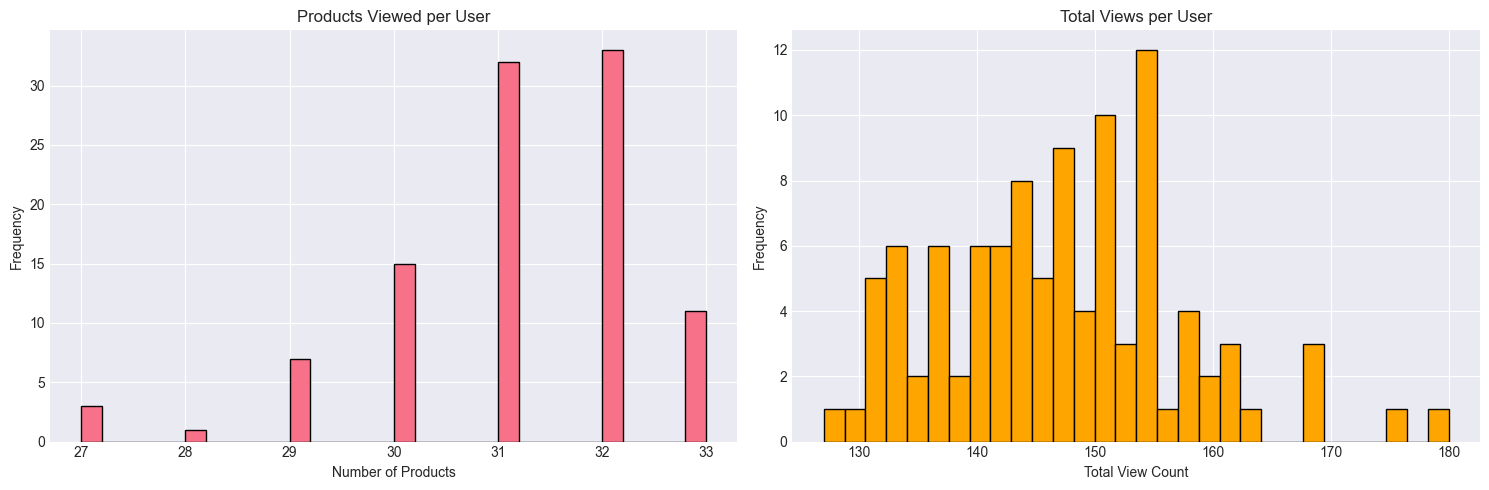

In [35]:
# View statistics
view_stats = df_views.groupby('user_id').agg({
    'product_id': 'count',
    'view_count': 'sum'
}).rename(columns={
    'product_id': 'num_products_viewed',
    'view_count': 'total_views'
})

print("VIEW STATISTICS:")
print(view_stats.describe())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(view_stats['num_products_viewed'], bins=30, edgecolor='black')
axes[0].set_title('Products Viewed per User')
axes[0].set_xlabel('Number of Products')
axes[0].set_ylabel('Frequency')

axes[1].hist(view_stats['total_views'], bins=30, edgecolor='black', color='orange')
axes[1].set_title('Total Views per User')
axes[1].set_xlabel('Total View Count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 8. Data Quality Summary & Recommendations

In [36]:
# Calculate key metrics
num_users = df_purchases['user_id'].nunique()
num_products = df_purchases['product_id'].nunique()
num_interactions = len(df_purchases)
avg_interactions_per_user = num_interactions / num_users
avg_interactions_per_product = num_interactions / num_products

print("\n" + "="*70)
print("DATA QUALITY SUMMARY FOR ML RECOMMENDATION SYSTEM")
print("="*70)
print(f"\nSCALE:")
print(f"  • Users: {num_users:,}")
print(f"  • Products: {num_products:,}")
print(f"  • Total Interactions (Purchases): {num_interactions:,}")
print(f"  • Avg purchases per user: {avg_interactions_per_user:.2f}")
print(f"  • Avg purchases per product: {avg_interactions_per_product:.2f}")

print(f"\nMATRIX METRICS:")
print(f"  • Matrix size: {num_users} × {num_products} = {num_users * num_products:,} cells")
print(f"  • Sparsity: {sparsity:.2%}")
print(f"  • Density: {(1-sparsity):.2%}")

print(f"\nCO-OCCURRENCE:")
print(f"  • Total product pairs: {len(df_cooccur):,}")
print(f"  • Strong pairs (5+ co-purchases): {len(df_cooccur[df_cooccur['count'] >= 5]):,}")

print(f"\nVIEWS (Implicit Feedback):")
print(f"  • Users with views: {df_views['user_id'].nunique():,}")
print(f"  • Products viewed: {df_views['product_id'].nunique():,}")
print(f"  • Total view records: {len(df_views):,}")

print("\n" + "="*70)


DATA QUALITY SUMMARY FOR ML RECOMMENDATION SYSTEM

SCALE:
  • Users: 102
  • Products: 33
  • Total Interactions (Purchases): 8,014
  • Avg purchases per user: 78.57
  • Avg purchases per product: 242.85

MATRIX METRICS:
  • Matrix size: 102 × 33 = 3,366 cells
  • Sparsity: 15.78%
  • Density: 84.22%

CO-OCCURRENCE:
  • Total product pairs: 527
  • Strong pairs (5+ co-purchases): 421

VIEWS (Implicit Feedback):
  • Users with views: 102
  • Products viewed: 33
  • Total view records: 3,173



## 9. Algorithm Selection Recommendations

In [37]:
print("\nALGORITHM SELECTION RECOMMENDATIONS")
print("="*70)

# Decision logic
recommendations = []

# 1. Check sparsity
if sparsity > 0.99:
    recommendations.append("VERY HIGH SPARSITY (>99%)")
    recommendations.append("   → Consider: Matrix Factorization (SVD, ALS)")
    recommendations.append("   → Avoid: Memory-based CF (too sparse)")
elif sparsity > 0.95:
    recommendations.append("HIGH SPARSITY (>95%)")
    recommendations.append("   → Recommended: Item-Based CF with dimensionality reduction")
    recommendations.append("   → Alternative: Matrix Factorization")
else:
    recommendations.append("MODERATE SPARSITY (<95%)")
    recommendations.append("   → Recommended: Item-Based Collaborative Filtering")
    recommendations.append("   → Also viable: User-Based CF")

# 2. Check co-occurrence strength
strong_pairs = len(df_cooccur[df_cooccur['count'] >= 5])
if strong_pairs > 100:
    recommendations.append("\nSTRONG CO-OCCURRENCE PATTERNS")
    recommendations.append("   → Excellent for: Item-Based CF (Frequent Pattern Mining)")
    recommendations.append("   → Can use: Association Rules (Apriori, FP-Growth)")
else:
    recommendations.append("\nWEAK CO-OCCURRENCE PATTERNS")
    recommendations.append("   → Consider: Content-Based Filtering (category, brand)")
    recommendations.append("   → Fallback: Popularity-based recommendations")

# 3. Check user behavior
if avg_interactions_per_user >= 5:
    recommendations.append("\nSUFFICIENT USER ACTIVITY")
    recommendations.append("   → User-Based CF: Viable")
    recommendations.append("   → Personalization: High potential")
else:
    recommendations.append("\nLIMITED USER ACTIVITY")
    recommendations.append("   → Focus on: Item-Based CF (more stable)")
    recommendations.append("   → Cold-start strategy: Needed for new users")

# 4. Check implicit feedback availability
view_coverage = df_views['user_id'].nunique() / num_users
if view_coverage > 0.5:
    recommendations.append("\nRICH IMPLICIT FEEDBACK (Views)")
    recommendations.append("   → Hybrid approach: Combine purchases + views")
    recommendations.append("   → Weighted scoring: purchase_weight=1.0, view_weight=0.3")
else:
    recommendations.append("\nLIMITED IMPLICIT FEEDBACK")
    recommendations.append("   → Focus on: Purchase data only")

# Print recommendations
for rec in recommendations:
    print(rec)

print("\n" + "="*70)


ALGORITHM SELECTION RECOMMENDATIONS
MODERATE SPARSITY (<95%)
   → Recommended: Item-Based Collaborative Filtering
   → Also viable: User-Based CF

STRONG CO-OCCURRENCE PATTERNS
   → Excellent for: Item-Based CF (Frequent Pattern Mining)
   → Can use: Association Rules (Apriori, FP-Growth)

SUFFICIENT USER ACTIVITY
   → User-Based CF: Viable
   → Personalization: High potential

RICH IMPLICIT FEEDBACK (Views)
   → Hybrid approach: Combine purchases + views
   → Weighted scoring: purchase_weight=1.0, view_weight=0.3



## 10. Final Recommendation

In [38]:
print("\nFINAL ALGORITHM RECOMMENDATION")
print("="*70)
print("\nBased on the data analysis, the recommended approach is:")
print("\n1️PRIMARY: Item-Based Collaborative Filtering")
print("   • Use co-occurrence matrix from purchase data")
print("   • Similarity metric: Cosine or Jaccard")
print("   • Min co-occurrence threshold: 2-5 purchases")
print("   • Use case: 'Customers who bought X also bought Y'")

if view_coverage > 0.5:
    print("\nENHANCEMENT: Hybrid with Implicit Feedback")
    print("   • Combine purchase + view signals")
    print("   • Weighted interaction score:")
    print("     - Purchase: weight = 1.0")
    print("     - View: weight = 0.2-0.3")

print("\nFALLBACK: Popularity-Based")
print("   • For cold-start (new users/products)")
print("   • Sort by: purchase_count, view_count, rating")

if num_products >= 50:
    print("\nOPTIONAL: Content-Based Features")
    print("   • Category similarity")
    print("   • Brand affinity")
    print("   • Price range matching")

print("\n" + "="*70)
print("\nReady to proceed with model training!")
print("Next steps:")
print("  1. Implement Item-Based CF algorithm")
print("  2. Build similarity matrix")
print("  3. Create recommendation service")
print("  4. Evaluate with offline metrics (precision, recall)")
print("="*70)


FINAL ALGORITHM RECOMMENDATION

Based on the data analysis, the recommended approach is:

1️PRIMARY: Item-Based Collaborative Filtering
   • Use co-occurrence matrix from purchase data
   • Similarity metric: Cosine or Jaccard
   • Min co-occurrence threshold: 2-5 purchases
   • Use case: 'Customers who bought X also bought Y'

ENHANCEMENT: Hybrid with Implicit Feedback
   • Combine purchase + view signals
   • Weighted interaction score:
     - Purchase: weight = 1.0
     - View: weight = 0.2-0.3

FALLBACK: Popularity-Based
   • For cold-start (new users/products)
   • Sort by: purchase_count, view_count, rating


Ready to proceed with model training!
Next steps:
  1. Implement Item-Based CF algorithm
  2. Build similarity matrix
  3. Create recommendation service
  4. Evaluate with offline metrics (precision, recall)
